In [1]:
import os
import glob
import numpy as np
import pandas as pd
import datetime as dt
from shapely.geometry import LineString, Point, Polygon, MultiPoint
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import CRS
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
import netCDF4 as nc
import shapely
shapely.speedups.enabled

%matplotlib inline


In [2]:
# IMERG data folder
#IMERG_folder = '/home/lzhou/Precipitation/IMERG/'
IMERG_folder = r'D:\Precipitation\IMERG'
# load track nodes that are within 500km of China boundary
#infile = '/home/lzhou/Precipitation/Precipitation_Scripts/Output/CMA_Tracks_Nodes_500km_wgs84.shp'
infile = r'D:/GitHub/Precipitation_Scripts/Output/CMA_Tracks_Nodes_500km.shp'
nodes = gpd.read_file(infile)
nodes_wgs84 = nodes.copy()
nodes_wgs84 = nodes_wgs84.to_crs(epsg=4326)

In [3]:
# check dimensions from IMERG data (ds)
#lons = ds['lon'][:]
#lats = ds['lat'][:]
#precip = ds['precipitationCal'][0,:,:]
#lat1, lon1 = np.meshgrid(lats, lons)
#lon2, lat2 = np.meshgrid(lons, lats)

#print(np.shape(lat1),np.shape(lon1))
#print(np.shape(lat2),np.shape(lat2))
#print(np.shape(precip))

# get the extent of rainfall area, for later use in subset IMERG data
minlon, minlat, maxlon, maxlat = nodes_wgs84.geometry.total_bounds
minlon = minlon-5; minlat=minlat-5; maxlon=maxlon+5; maxlat=maxlat+5
#print(minlon,minlat,maxlon,maxlat)

#Prepare coordinates for precipitation data

lons1 = np.arange(-179.95,180,0.1)
lats1 = np.arange(-89.95,90,0.1)

idlon2 = int((maxlon-lons1[0])/0.1)
#print(lons1[idx2],maxx)
idlon1 = int((minlon-lons1[0])/0.1)
#print(lons1[idx1],minx)
idlat2 = int((maxlat-lats1[0])/0.1)
#print(lats[idy2],maxy)
idlat1 = int((minlat-lats1[0])/0.1)
#print(lats[idy1],miny)

latitude = lats1[idlat1:idlat2+1]
longitude = lons1[idlon1:idlon2+1]
#print('lat: ',latitude.shape,'  lon: ',longitude.shape)

lat,lon = np.meshgrid(latitude,longitude)
lon1d = np.reshape(lon,-1)
lat1d = np.reshape(lat,-1)
#print(lon.shape)

x = np.array([0, 1, 2])
y = np.array([0, 1])
X, Y = np.meshgrid(x, y)
print('x.shape: ', x.shape)
print('y.shape: ', y.shape)
print(X.shape,Y.shape)

In [4]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
china = world[world.name=='China'].copy()

In [5]:
#m=china.boundary.plot()
#nodes[(nodes.Year==2018)&(nodes.InYearID==9)].plot(ax=m)
#track = nodes_wgs84[(nodes_wgs84.Year==2019)&(nodes_wgs84.InYearID==12)].reset_index(drop=True) # Lekima
track = nodes_wgs84[(nodes_wgs84.Year==2017)&(nodes_wgs84.InYearID==14)].reset_index(drop=True) # Hato

#print(track.head(1))
#print(track.tail(1))

In [6]:
# get list of IMERG files, sorted.
##
#"3B-DAY.MS.MRG.3IMERG.20011030-S000000-E235959.V06.nc4"
track['filename'] = track['Year']*10000+track['Month']*100+track['Day']
track['filename'] = track['filename'].astype('str')
filenames = track.filename.unique()

test=np.array([lat1d,lon1d,precip1d])

df = pd.DataFrame(test,columns=['lat','lon','precip'])
#precip_daily['Precipitation']=precip1d
df['geometry'] = df.apply(lambda x: Point((float(x.lon),float(x.lat))),axis=1)
df = gpd.GeoDataFrame(df,geometry='geometry')
df.head()

df.crs = CRS.from_epsg(4326)

#sns.color_palette("light:b", as_cmap=True)
m = df.plot(column='precip',cmap='Blues',figsize=(8,8),legend=True)
china.boundary.plot(color='black',ax=m)
track_buffer.boundary.plot(ax=m,color='yellow',linewidth=1)

# this is just to test the dimensions. And it turned out that the precip should be transposed.
filename = "3B-DAY.MS.MRG.3IMERG."+filenames[0]+"-S000000-E235959.V06.nc4"
infile = os.path.join(IMERG_folder,filename)
print(infile, ' ',os.path.isfile(infile))

# find files that are needed (not use)
#firstday=dt.date(2000,6,1)
#startdate = dt.date(track.loc[0,'Year'],track.loc[0,'Month'],track.loc[0,'Day'])
#startdate = dt.date(2001,6,1)
#deltaday = startdate-firstday
#delta = deltaday.days
#sort_files[delta]
#fn = os.path.join(infolder,sort_files[delta])
#print(fn)

ds = nc.Dataset(infile,'r')

# check dimensions from IMERG data (ds)
lons = ds['lon'][:]
lats = ds['lat'][:]
precip = ds['precipitationCal'][0,:,:]
laa,loo = np.meshgrid(lats,lons)
print(precip.shape, laa.shape,loo.shape)

In [7]:
##
#filename = "3B-DAY.MS.MRG.3IMERG."+track.loc[0,'filename']+"-S000000-E235959.V06.nc4"
first_call = 1
for ii in np.arange(0,len(filenames)):
    filename = "3B-DAY.MS.MRG.3IMERG."+filenames[ii]+"-S000000-E235959.V06.nc4"
    infile = os.path.join(IMERG_folder,filename)
    print(infile, ' ',os.path.isfile(infile))

# find files that are needed (not use)
#firstday=dt.date(2000,6,1)
#startdate = dt.date(track.loc[0,'Year'],track.loc[0,'Month'],track.loc[0,'Day'])
#startdate = dt.date(2001,6,1)
#deltaday = startdate-firstday
#delta = deltaday.days
#sort_files[delta]
#fn = os.path.join(infolder,sort_files[delta])
#print(fn)

    ds = nc.Dataset(infile,'r')
    precip = ds['precipitationCal'][0,idlon1:idlon2+1,idlat1:idlat2+1]
    precip1d = np.reshape(precip,-1)
    dummy = np.array([lat1d,lon1d,precip1d])
    print(dummy.shape)
    df = pd.DataFrame(dummy.T,columns=['lat','lon','precip'])
    df['Time'] = filenames[ii]
    df['CMAID'] = track.loc[0,'CMAID']
    if first_call == 1:
        precip_daily = df.copy()
        first_call = 0
    else: 
        precip_daily = precip_daily.append(df)

D:\Precipitation\IMERG\3B-DAY.MS.MRG.3IMERG.20170822-S000000-E235959.V06.nc4   True
(3, 280872)
D:\Precipitation\IMERG\3B-DAY.MS.MRG.3IMERG.20170823-S000000-E235959.V06.nc4   True
(3, 280872)
D:\Precipitation\IMERG\3B-DAY.MS.MRG.3IMERG.20170824-S000000-E235959.V06.nc4   True
(3, 280872)
D:\Precipitation\IMERG\3B-DAY.MS.MRG.3IMERG.20170825-S000000-E235959.V06.nc4   True
(3, 280872)


In [8]:
%%time
init_epsg=4326
precip_daily['geometry'] = precip_daily.apply(lambda x: Point((float(x.lon),float(x.lat))),axis=1)
precip_daily = gpd.GeoDataFrame(precip_daily,geometry='geometry')
precip_daily.crs = CRS.from_epsg(init_epsg)

Wall time: 26.3 s


Wall time: 2min 51s


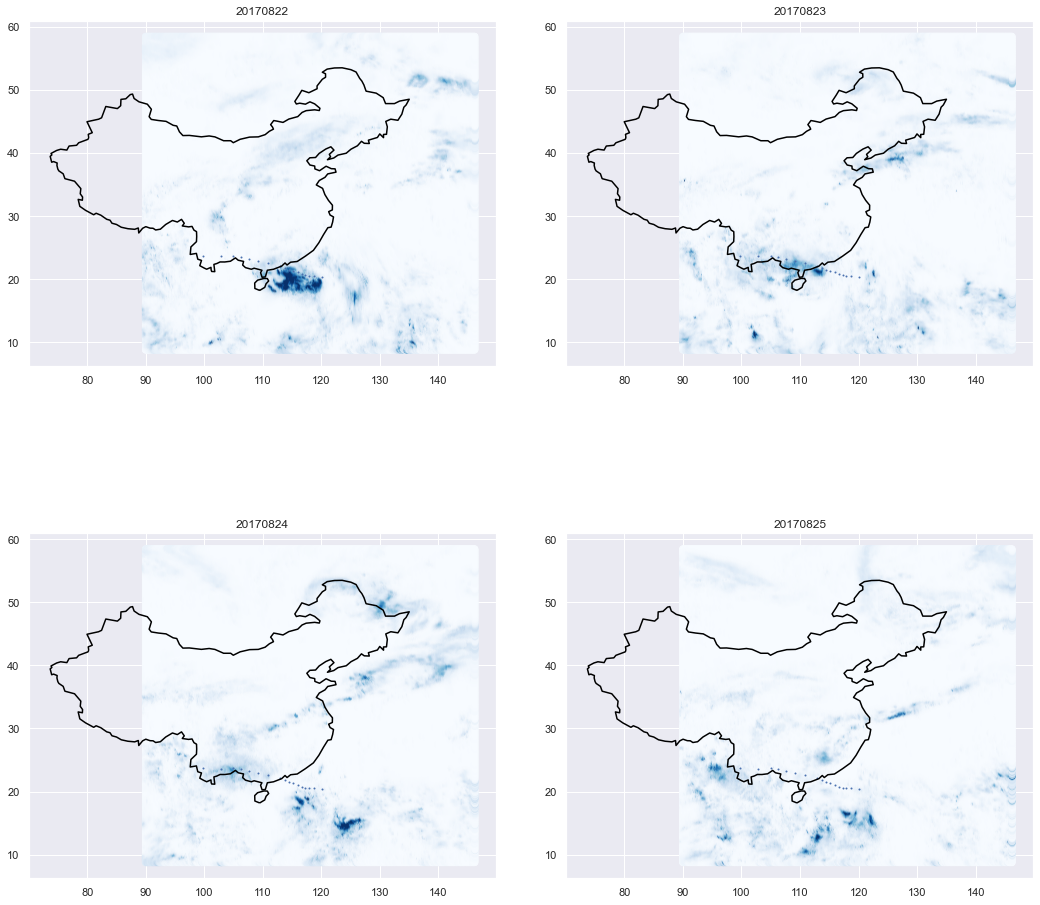

In [18]:
%%time
fig, axs = plt.subplots(2,2,figsize=(18,18))
fig.subplots_adjust(hspace =0.1, wspace=0.15)
axs = axs.ravel()
jj = 0
grouped = precip_daily.groupby('Time')
for name, group in grouped:
    #print(name)
    m = axs[jj]
    group.plot(column='precip',cmap='Blues',vmin=0,vmax=200,ax=m)
    china.boundary.plot(color='black',ax=m)
    track.plot(ax=m,markersize=1)
    m.title.set_text(name)

    jj = jj+1
    
fig.savefig('2017_Hato.png')

#CMPA 3km data
#CMPA_folder = '/home/lzhou/Precipitation/CMPA/CMPA_3km/201908'
CMPA_folder = r'I:\Precipitation\cmpa\cmpa_3km\201908'
files = os.listdir(CMPA_folder)
#R01H_FRT_2019080100.npy
files = [x for x in files if '20190809' in x]

first_call = 1
for x in files:
    dummy = np.load(os.path.join(CMPA_folder,x))
    if first_call == 1:
        daily_sum = dummy.copy()
        first_call = 0
    else:
        daily_sum = daily_sum + dummy
        

daily_sum.shape

In [10]:
cmpa_lon = np.arange(97.05,122.41,0.05)
cmpa_lat = np.arange(17.2,30.41,0.05)
cmpalon,cmpalat = np.meshgrid(cmpa_lon,cmpa_lat)
cmpalon1d = np.reshape(cmpalon,-1)
cmpalat1d = np.reshape(cmpalat,-1)

In [11]:
##
#filename = "3B-DAY.MS.MRG.3IMERG."+track.loc[0,'filename']+"-S000000-E235959.V06.nc4"
CMPA_folder = r'I:\Precipitation\cmpa\cmpa_3km\201708'
files = os.listdir(CMPA_folder)

first_call = 1
for ii in filenames:
    first_file = 1
    day_files = [x for x in files if ii in x]
    for jj in day_files:
        dummy = np.load(os.path.join(CMPA_folder,jj))
        if first_file == 1:
            daily_sum = dummy.copy()
            first_file = 0
        else:
            daily_sum = daily_sum + dummy
    daily_sum1d = np.reshape(daily_sum,-1)
    
    cmpa_day = np.array([cmpalat1d,cmpalon1d,daily_sum1d])
    #print(cmpa_day.shape)
    df = pd.DataFrame(cmpa_day.T,columns=['lat','lon','cmpa'])
    df['Time'] = ii
    
    if first_call == 1:
        cmpa_daily = df.copy()
        first_call = 0
    else: 
        cmpa_daily = cmpa_daily.append(df)

<AxesSubplot:>

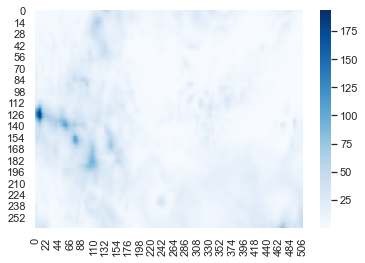

In [16]:
sns.heatmap(daily_sum,cmap='Blues')

In [12]:
%%time
cmpa_daily['geometry'] = cmpa_daily.apply(lambda x: Point((float(x.lon),float(x.lat))),axis=1)
cmpa_daily = gpd.GeoDataFrame(cmpa_daily,geometry='geometry')
cmpa_daily.crs = CRS.from_epsg(init_epsg)

Wall time: 13.3 s


Wall time: 1min 18s


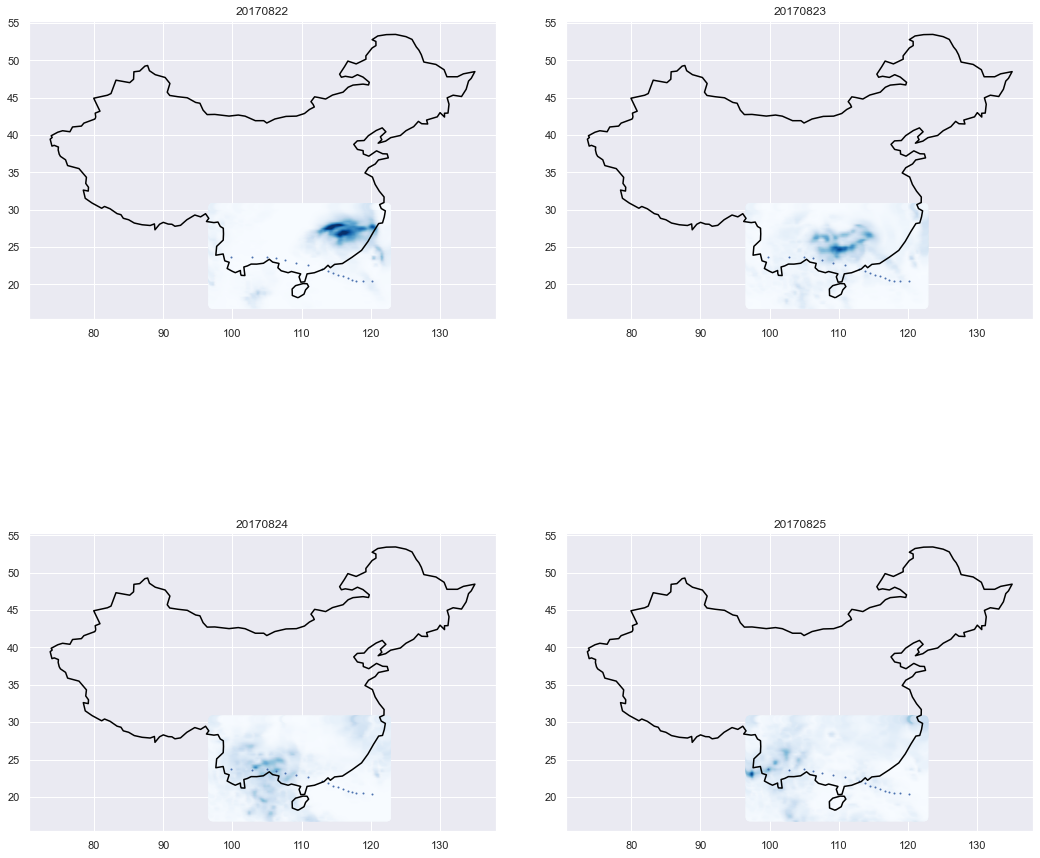

In [17]:
%%time
fig, axs = plt.subplots(2,2,figsize=(18,18))
fig.subplots_adjust(hspace =0.1, wspace=0.15)
axs = axs.ravel()
jj = 0
grouped = cmpa_daily.groupby('Time')
for name, group in grouped:
    #print(name)
    m = axs[jj]
    group.plot(column='cmpa',cmap='Blues',vmin=0,vmax=200,ax=m)
    china.boundary.plot(color='black',ax=m)
    track.plot(ax=m,markersize=1)
    m.title.set_text(name)

    jj = jj+1
    
fig.savefig('2017_Hato_cmpa.png')